In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/celebe-real/id1_0006.mp4
/kaggle/input/celebe-real/id0_0005.mp4
/kaggle/input/celebe-real/id0_0008.mp4
/kaggle/input/celebe-real/id3_0008.mp4
/kaggle/input/celebe-real/id2_0007.mp4
/kaggle/input/celebe-real/id2_0000.mp4
/kaggle/input/celebe-real/id3_0004.mp4
/kaggle/input/celebe-real/id4_0002.mp4
/kaggle/input/celebe-real/id0_0009.mp4
/kaggle/input/celebe-real/id2_0006.mp4
/kaggle/input/celebe-real/id1_0008.mp4
/kaggle/input/celebe-real/id2_0002.mp4
/kaggle/input/celebe-real/id4_0003.mp4
/kaggle/input/celebe-real/id1_0001.mp4
/kaggle/input/celebe-real/id0_0002.mp4
/kaggle/input/celebe-real/id3_0000.mp4
/kaggle/input/celebe-real/id0_0001.mp4
/kaggle/input/celebe-real/id3_0003.mp4
/kaggle/input/celebe-real/id1_0004.mp4
/kaggle/input/celebe-real/id3_0009.mp4
/kaggle/input/celebe-real/id3_0006.mp4
/kaggle/input/celebe-real/id4_0000.mp4
/kaggle/input/celebe-real/id3_0007.mp4
/kaggle/input/celebe-real/id3_0005.mp4
/kaggle/input/celebe-real/id1_0009.mp4
/kaggle/input/celebe-real

### Add imports

In [97]:
!git clone https://github.com/rkuo2000/facenet-pytorch facenet_pytorch

fatal: destination path 'facenet_pytorch' already exists and is not an empty directory.


In [98]:
import cv2
import torch
import numpy as np
import timm
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import datetime
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image as ImageDisplay
import matplotlib.cm as cm

### Model

In [99]:
# Carregar modelo XceptionNet pré-treinado para detecção de deepfakes
class DeepfakeDetector(torch.nn.Module):
    def __init__(self):
        super(DeepfakeDetector, self).__init__()
        self.model = timm.create_model("xception", pretrained=True, num_classes=2)

    def forward(self, x):
        return self.model(x)

In [100]:
# Inicializar modelo e definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeDetector().to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


DeepfakeDetector(
  (model): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(in

### Prepare for Detection

In [101]:
# Transformações para normalização
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [102]:
# Função para extrair frames do vídeo
def extract_frames(video_path, interval=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    return frames

In [103]:
# Criar ou limpar o diretório para armazenar as faces extraídas
output_dir = "faces-extraidas"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Remove todos os arquivos da pasta
os.makedirs(output_dir, exist_ok=True)  # Recria a pasta limpa

# Função para detectar rostos nos frames usando MTCNN
def detect_faces(frames):
    mtcnn = MTCNN(keep_all=True, device=device)
    faces = []
    for i, frame in enumerate(frames):
#    for frame in frames:
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        boxes, _ = mtcnn.detect(image)

#        if boxes is not None:
#            for box in boxes:
#                x1, y1, x2, y2 = map(int, box)
#                face = image.crop((x1, y1, x2, y2))
#                faces.append((frame, face))

        if boxes is not None:
            for j, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                face = image.crop((x1, y1, x2, y2))
                
                # Sa+
                # var a face extraída como imagem
                face_filename = os.path.join(output_dir, f"frame_{i}_face_{j}.jpg")
                face.save(face_filename)

                # Adicionar à lista de resultados
                faces.append((frame, face))

    return faces

In [104]:
# Função para classificar rostos como real ou deepfake
def classify_faces(faces):
    real_count = 0
    fake_count = 0
    
    results = []
    
    for frame, face in faces:
        face = transform(face).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(face)
            prob = torch.softmax(output, dim=1)[0]
            label = "Deepfake" if prob[1] > prob[0] else "Real"
            confidence = prob[1].item() if label == "Deepfake" else prob[0].item()
            results.append((frame, label, confidence))
            
            if label == "Fake":
                fake_count += 1
            else:
                real_count += 1
    detection = "Fake" if fake_count > real_count else "Real"
    return results, detection

In [105]:
# Função para exibir resultados
def display_results(results):
    df = pd.DataFrame(results, columns=["Frame", "Classificação", "Confiança"])
    df.drop(columns=["Frame"], inplace=True)
    print(df)

    plt.figure(figsize=(8, 5))
    real_count = sum(1 for _, label, _ in results if label == "Real")
    deepfake_count = sum(1 for _, label, _ in results if label == "Deepfake")
    
    plt.bar(["Real", "Deepfake"], [real_count, deepfake_count], color=["blue", "red"])
    plt.title("Distribuição de Detecção de Deepfakes")
    plt.ylabel("Número de Frames")
    plt.show()

In [106]:
# Pipeline completo
def detect_deepfakes(video_path):
    print("Extraindo quadros...")
    frames = extract_frames(video_path)

    print("Detectando rostos...")
    faces = detect_faces(frames)

    print("Classificando rostos...")
    results, detection = classify_faces(faces)

    print("Exibindo resultados...")
    display_results(results)

### Detect Videos

Extraindo quadros...
Detectando rostos...
Classificando rostos...
Exibindo resultados...
   Classificação  Confiança
0           Real   0.576020
1           Real   0.564999
2           Real   0.569243
3           Real   0.550829
4           Real   0.558332
..           ...        ...
68          Real   0.554335
69          Real   0.548182
70          Real   0.584725
71          Real   0.568406
72          Real   0.556636

[73 rows x 2 columns]


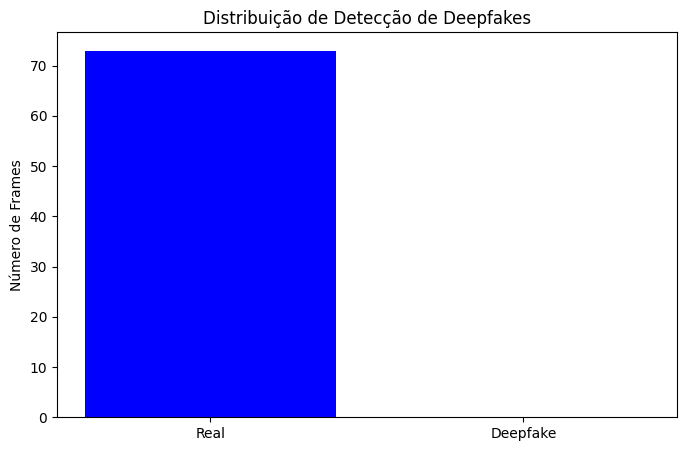

In [107]:
# Executar a detecção em um vídeo MP4 Real
video_file = "/kaggle/input/celebe-real/id1_0000.mp4"      # Real

detect_deepfakes(video_file)

Extraindo quadros...
Detectando rostos...


/kaggle/working/facenet_pytorch/models/mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)
/kaggle/working/facenet_pytorch/mo

Classificando rostos...
Exibindo resultados...
    Classificação  Confiança
0            Real   0.627100
1            Real   0.621894
2            Real   0.520028
3            Real   0.609806
4            Real   0.542772
..            ...        ...
105          Real   0.576427
106          Real   0.573293
107          Real   0.574112
108          Real   0.587925
109          Real   0.579267

[110 rows x 2 columns]


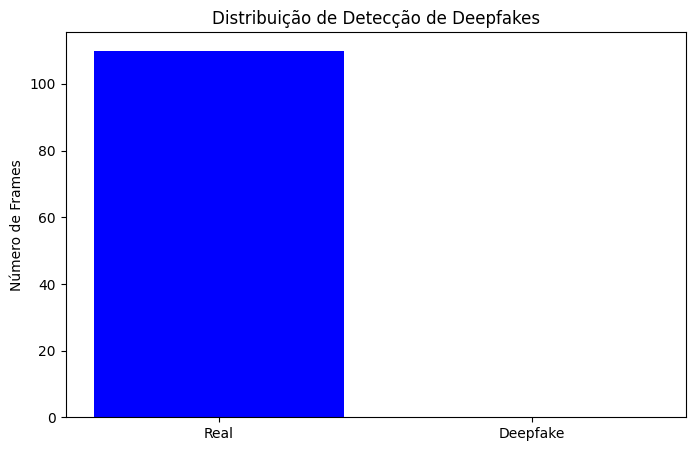

In [108]:
# Executar a detecção em um vídeo MP4 Fake
video_file = "/kaggle/input/celeb-fake/id0_id3_0009.mp4"

detect_deepfakes(video_file)

In [109]:
# Função para processar vídeos no diretório e gerar matriz de confusão
def evaluate_videos(video_dir):
    initial_time = datetime.datetime.now()
    print(f"Start at {initial_time.strftime('%d-%m-%Y %H:%M:%S')}")
    
    true_labels = []
    pred_labels = []

    for class_label in  ["Real", "Deepfake"]:

        class_label_dir = ""
        if class_label == "Real":
            class_label_dir = "celebe-real"
        else:
            class_label_dir = "celeb-fake"
            
        class_dir = os.path.join(video_dir, class_label_dir)
        print(class_dir)

        if not os.path.exists(class_dir):
            continue

        # Listar apenas os primeiros 10 arquivos de cada categoria (Real e Fake)
        video_files = sorted([f for f in os.listdir(class_dir) if f.endswith(".mp4")])

        #for video_file in os.listdir(class_dir):
        for video_file in video_files:
            if video_file.endswith(".mp4"):
                video_path = os.path.join(class_dir, video_file)
                print(f"\nProcessando: {video_file} ({class_label})")

                # Extração de frames e detecção de deepfake
                frames = extract_frames(video_path)
                faces = detect_faces(frames)

                if not faces:
                    print(f"Aviso: Nenhum rosto detectado no vídeo {video_file}. Classificação padrão como 'Real'.")
                    pred_label = "Real"
                else:
                    results, detection = classify_faces(faces)
                    pred_label = detection

                # Salvar rótulos reais e preditos
                true_labels.append(class_label)
                pred_labels.append(pred_label)

    # Gerar matriz de confusão
    cm = confusion_matrix(true_labels, pred_labels, labels=["Real", "Deepfake"])
    df_cm = pd.DataFrame(cm, index=["Real", "Deepfake"], columns=["Predito Real", "Predito Deepfake"])

    # Exibir matriz de confusão
    plt.figure(figsize=(6, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predição")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão - Detecção de Deepfake")
    plt.show()

    # Exibir relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(true_labels, pred_labels, target_names=["Real", "Deepfake"]))

    final_time = datetime.datetime.now()
    duration = final_time - initial_time
    print(f"Finish at {final_time.strftime('%d-%m-%Y %H:%M:%S')}, duration: {duration}")

Start at 06-03-2025 20:45:02
/kaggle/input/celebe-real

Processando: id0_0000.mp4 (Real)


/kaggle/working/facenet_pytorch/models/mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)
/kaggle/working/facenet_pytorch/mo


Processando: id0_0001.mp4 (Real)

Processando: id0_0002.mp4 (Real)

Processando: id0_0003.mp4 (Real)

Processando: id0_0004.mp4 (Real)

Processando: id0_0005.mp4 (Real)

Processando: id0_0006.mp4 (Real)

Processando: id0_0007.mp4 (Real)

Processando: id0_0008.mp4 (Real)

Processando: id0_0009.mp4 (Real)

Processando: id1_0000.mp4 (Real)

Processando: id1_0001.mp4 (Real)

Processando: id1_0002.mp4 (Real)

Processando: id1_0003.mp4 (Real)

Processando: id1_0004.mp4 (Real)

Processando: id1_0005.mp4 (Real)

Processando: id1_0006.mp4 (Real)

Processando: id1_0007.mp4 (Real)

Processando: id1_0008.mp4 (Real)

Processando: id1_0009.mp4 (Real)

Processando: id2_0000.mp4 (Real)

Processando: id2_0001.mp4 (Real)

Processando: id2_0002.mp4 (Real)

Processando: id2_0003.mp4 (Real)

Processando: id2_0004.mp4 (Real)

Processando: id2_0005.mp4 (Real)

Processando: id2_0006.mp4 (Real)

Processando: id2_0007.mp4 (Real)

Processando: id2_0008.mp4 (Real)

Processando: id2_0009.mp4 (Real)

Processando: 

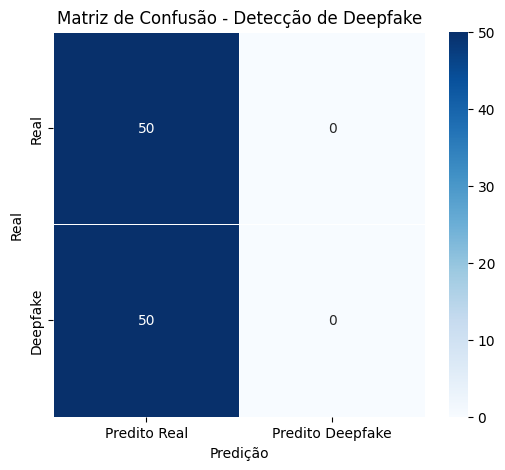


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00        50
    Deepfake       0.50      1.00      0.67        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100

Finish at 06-03-2025 21:17:23, duration: 0:32:20.570466


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [110]:
## Diretório de vídeos de teste
video_test_dir = "/kaggle/input/"

# Avaliação de todos os vídeos no diretório
evaluate_videos(video_test_dir)

### Explainable AI - In progress

In [118]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# Preprocess the image for the model
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize if required by the model
    return img

# Generate Grad-CAM heatmap for a specific class index
def grad_cam(model, image, class_idx, target_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(target_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_idx] if predictions.shape[1] > 1 else predictions[:, 0]
    
    grads = tape.gradient(loss, conv_outputs)

    # Global average pooling the gradients
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))  # Mean over height and width
    conv_outputs = conv_outputs[0]  # Remove batch dimension

    # Multiply each channel in the convolutional output by its corresponding weight
    weighted_conv_outputs = tf.reduce_sum(conv_outputs * weights, axis=-1)

    # Apply ReLU and normalize
    heatmap = np.maximum(weighted_conv_outputs, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    return heatmap

# Overlay the Grad-CAM heatmap on the original image and display the prediction
def overlay_heatmap(heatmap, image_path, model, class_idx, alpha=0.4, target_size=(256, 256)):
    # Preprocess the image to match the model's input size
    img_preprocessed = preprocess_image(image_path, target_size)
    
    # Get the model prediction for the image
    prediction = model.predict(img_preprocessed)  # Already normalized in preprocess_image
    print(f"Raw Prediction: {prediction}")

    pred_class = 1 if prediction[0] > 0.5 else 0  # Binary classification threshold
    pred_prob = prediction[0][0] if pred_class == 1 else 1 - prediction[0][0]

    label = 'Real' if pred_class == 1 else 'Deepfake'
    print(f"Prediction: {label} with {pred_prob*100:.2f}% confidence")

    # Load the original image for visualization
    img = img_to_array(load_img(image_path)).astype('uint8')  # Ensure img is uint8

    # Scale and resize heatmap
    heatmap = np.uint8(255 * heatmap)  # Scale heatmap to 0-255
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize to original img size

    # Convert heatmap to RGB using colormap and drop alpha channel
    heatmap_colored = cm.jet(heatmap / 255.0)  # Apply colormap
    heatmap_colored = np.uint8(255 * heatmap_colored[..., :3])  # Keep only RGB channels

    # Ensure the heatmap and image have the same dimensions
    if heatmap_colored.shape[:2] != img.shape[:2]:
        heatmap_colored = cv2.resize(heatmap_colored, (img.shape[1], img.shape[0]))

    # Create the overlay
    overlayed = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)

    # Display the result
    plt.imshow(overlayed)
    plt.title(f"{label} ({pred_prob*100:.2f}%)")
    plt.axis('off')
    plt.show()

# Example Usage
target_layer_name = "block12"  # Modify based on your model's architecture
image_path = "/kaggle/working/faces-extraidas/frame_49_face_1.jpg"
preprocessed_image = preprocess_image(image_path, target_size=(256, 256))
class_idx = 1  # Use 1 for 'real', 0 for 'fake'
heatmap = grad_cam(model, preprocessed_image, class_idx, target_layer_name)
overlay_heatmap(heatmap, image_path, model, class_idx)

AttributeError: 'DeepfakeDetector' object has no attribute 'input'